# Visualize XAI
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import cmocean
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy as ct
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import silence_tensorflow
silence_tensorflow

import scipy.stats as stats
import seaborn as sns
import cmaps as cmaps_ncl

import experiment_settings
import file_methods, plots, data_processing, xai

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


In [3]:
FS = 10

### for white background...
plt.rc('text',usetex=True)
# plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## User Choices

In [4]:
EXP_NAME = 'exp15C_370'#'exp15C_370'

#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

{'save_model': True,
 'n_models': 10,
 'ssp': '370',
 'gcmsub': 'ALL',
 'obsdata': 'BEST',
 'smooth': False,
 'target_temp': 1.5,
 'n_train_val_test': (7, 2, 1),
 'baseline_yr_bounds': (1850, 1899),
 'training_yr_bounds': (1970, 2100),
 'anomaly_yr_bounds': (1951, 1980),
 'remove_sh': False,
 'anomalies': True,
 'remove_map_mean': False,
 'network_type': 'shash2',
 'hiddens': [25, 25],
 'dropout_rate': 0.0,
 'ridge_param': [10.0, 0.0],
 'learning_rate': 1e-05,
 'batch_size': 64,
 'rng_seed': 8889,
 'seed': None,
 'act_fun': ['relu', 'relu'],
 'n_epochs': 25000,
 'patience': 50,
 'exp_name': 'exp15C_370'}

## Initial housekeeping

In [5]:
# get seed to plot
df_metrics = pd.read_pickle(PREDICTIONS_DIRECTORY + "df_random_seed.pickle")
df = df_metrics[df_metrics["exp_name"]==EXP_NAME]
PLOT_SEED = df_metrics.iloc[df['loss_val'].idxmin()]["seed"]
PLOT_SEED = 2247
print('PLOT_SEED = ' + str(PLOT_SEED))

## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)


PLOT_SEED = 2247


## Load the Model

In [6]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get model name
model_name = file_methods.get_model_name(settings)
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

## Get the obs data

In [7]:
settings["obsdata"] = 'BEST'
da_obs_best, x_obs_best, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_best = data_processing.compute_global_mean(da_obs_best)

settings["obsdata"] = 'BESTANOM'
da_obs_besta, x_obs_besta, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_besta = data_processing.compute_global_mean(da_obs_best)

settings["obsdata"] = 'GISS'
da_obs_giss, x_obs_giss, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_giss = data_processing.compute_global_mean(da_obs_giss)

settings["obsdata"] = 'NCEP'
da_obs_ncep, x_obs_ncep, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_ncep = data_processing.compute_global_mean(da_obs_ncep)

settings["obsdata"] = 'ERA5'
da_obs_era, x_obs_era, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_era = data_processing.compute_global_mean(da_obs_era)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (142, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (74, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (72, 10368)


In [8]:
i = np.where(x_obs_best[-1,:].flatten()==0)[0]
print(len(i))
i = np.where(x_obs_besta[-1,:].flatten()==0)[0]
print(len(i))
i = np.where(x_obs_giss[-1,:].flatten()==0)[0]
print(len(i))
i = np.where(x_obs_ncep[-1,:].flatten()==0)[0]
print(len(i))
i = np.where(x_obs_era[-1,:].flatten()==0)[0]
print(len(i))

3
3
179
0
0


# Plot the results

13.779304 13.779376 12.967082 22.096386 13.878789


2022-04-14 20:12:15.918583: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


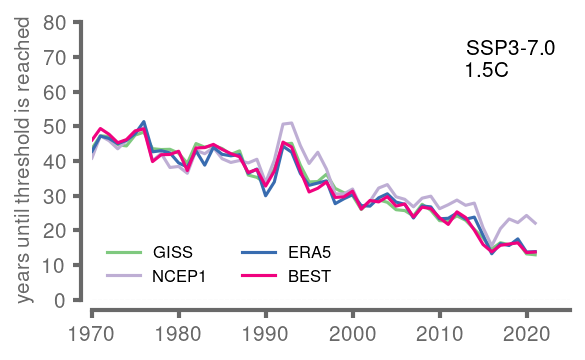

In [9]:
cmap = mpl.cm.get_cmap('Accent').colors

mu_giss = []
mu_best = []
mu_besta = []
mu_ncep = []

best_pred = model.predict(da_obs_best.values.reshape((da_obs_best.shape[0],len(da_obs_best["lat"])*len(da_obs_best["lon"]))))
besta_pred = model.predict(da_obs_besta.values.reshape((da_obs_besta.shape[0],len(da_obs_besta["lat"])*len(da_obs_best["lon"]))))
giss_pred = model.predict(da_obs_giss.values.reshape((da_obs_giss.shape[0],len(da_obs_giss["lat"])*len(da_obs_giss["lon"]))))
ncep_pred = model.predict(da_obs_ncep.values.reshape((da_obs_ncep.shape[0],len(da_obs_ncep["lat"])*len(da_obs_ncep["lon"]))))
era_pred = model.predict(da_obs_era.values.reshape((da_obs_era.shape[0],len(da_obs_era["lat"])*len(da_obs_era["lon"]))))

print(best_pred[-1,0],besta_pred[-1,0],giss_pred[-1,0],ncep_pred[-1,0],era_pred[-1,0])

plt.figure(figsize=(4,2.5))

plt.plot(da_obs_giss["time.year"],giss_pred[:,0],label='GISS',color=cmap[0])
plt.plot(da_obs_ncep["time.year"],ncep_pred[:,0],label='NCEP1',color=cmap[1])
plt.plot(da_obs_era["time.year"],era_pred[:,0],label='ERA5',color=cmap[4])
plt.plot(da_obs_best["time.year"],best_pred[:,0],label='BEST',color=cmap[5])

format_spines(plt.gca())
plt.ylabel('years until threshold is reached')
# plt.title(settings["exp_name"])
plt.yticks(np.arange(-90,90,10),np.arange(-90,90,10))
plt.xticks(np.arange(1970,2025,10),np.arange(1970,2025,10))
plt.xlim(1970,2025)
if(settings["target_temp"]==1.1):
    plt.ylim(-10,80)
    plt.legend(frameon=False,fontsize=FS*0.8,loc="upper left", ncol=2)    
else:
    plt.ylim(0,80)
    plt.axhline(y=0,linewidth=.5,color='dimgray',linestyle='--',zorder=0,)
    plt.legend(frameon=False,fontsize=FS*0.8,loc="lower left", ncol=2)    

exp_name = settings["exp_name"]
text_name = 'SSP'+exp_name[7]+'-'+exp_name[8] + '.' + exp_name[9] + '\n' +exp_name[3] + '.' + exp_name[4]+'C'
plt.text(2013,
         75,
         text_name,
         fontsize=FS,
         color='k',
         horizontalalignment='left',
         verticalalignment='top',
        )

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name + '_timeseries_four_obs_datasets',dpi=savefig_dpi)

plt.show()

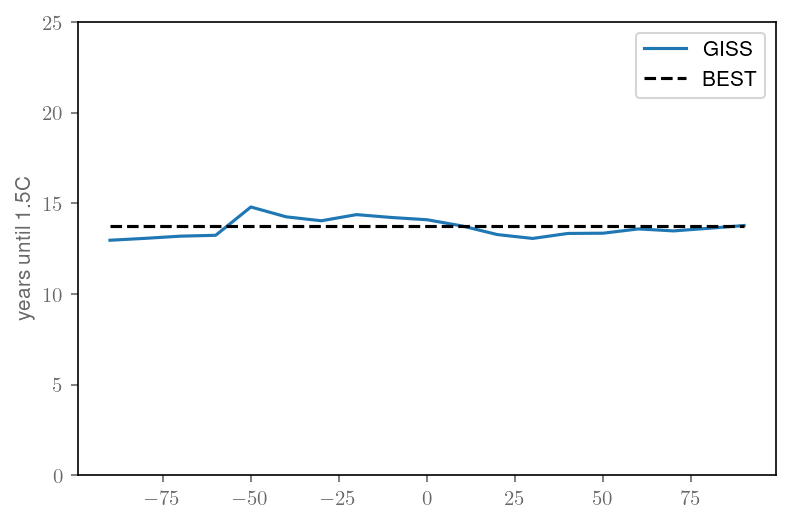

In [10]:
mu_giss = []
mu_best = []
for lat_cut in np.arange(-90,100,10):
    b = copy.deepcopy(x_obs_best[-1])
    a = copy.deepcopy(x_obs_giss[-1])

    a = a.reshape(len(da_obs_giss["lat"]),len(da_obs_giss["lon"]))
    b = b.reshape(len(da_obs_best["lat"]),len(da_obs_best["lon"]))
    ilat = np.where(da_obs_giss["lat"]<lat_cut)[0]
    a[ilat,:] = copy.deepcopy(b[ilat,:])
    a = a.reshape(len(da_obs_giss["lat"])*len(da_obs_giss["lon"]))
    b = b.reshape(len(da_obs_best["lat"])*len(da_obs_best["lon"]))
    
    mu_giss.append(model.predict(a[np.newaxis,:])[0][0])
    mu_best.append(model.predict(b[np.newaxis,:])[0][0])
    
plt.figure()
plt.plot(np.arange(-90,100,10),mu_giss,label='GISS')
plt.plot(np.arange(-90,100,10),mu_best,'--k',label='BEST')
plt.ylabel('years until 1.5C')
plt.legend()
plt.ylim(0,25)
plt.show()

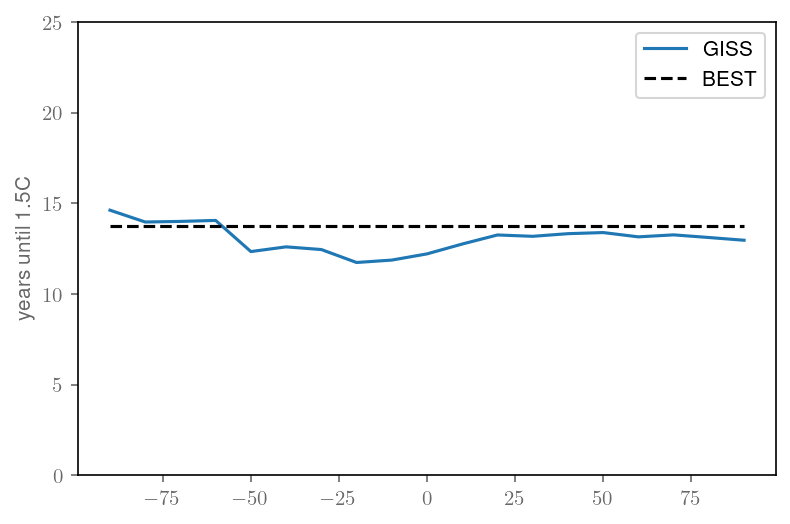

In [11]:
mu_giss = []
mu_best = []
for lat_cut in np.arange(-90,100,10):
    b = copy.deepcopy(x_obs_best[-1])
    a = copy.deepcopy(x_obs_giss[-1])

    a = a.reshape(len(da_obs_giss["lat"]),len(da_obs_giss["lon"]))
    b = b.reshape(len(da_obs_best["lat"]),len(da_obs_best["lon"]))
    ilat = np.where((da_obs_giss["lat"]>lat_cut) & (da_obs_giss["lat"]<lat_cut+45))[0]
    # print(da_obs_giss["lat"][ilat])
    a[ilat,:] = copy.deepcopy(b[ilat,:])
    a = a.reshape(len(da_obs_giss["lat"])*len(da_obs_giss["lon"]))
    b = b.reshape(len(da_obs_best["lat"])*len(da_obs_best["lon"]))
    
    mu_giss.append(model.predict(a[np.newaxis,:])[0][0])
    mu_best.append(model.predict(b[np.newaxis,:])[0][0])
    
plt.figure()
plt.plot(np.arange(-90,100,10),mu_giss,label='GISS')
plt.plot(np.arange(-90,100,10),mu_best,'--k',label='BEST')
plt.ylabel('years until 1.5C')
plt.legend()
plt.ylim(0,25)
plt.show()

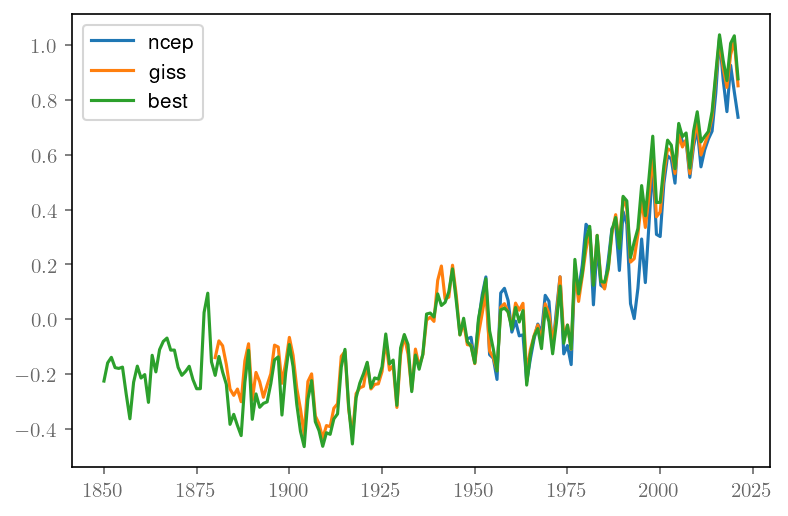

In [12]:
plt.plot(da_obs_ncep["time.year"],global_mean_obs_ncep,label='ncep')
plt.plot(da_obs_giss["time.year"],global_mean_obs_giss,label='giss')
plt.plot(da_obs_best["time.year"],global_mean_obs_best,label='best')
plt.legend()
plt.show()

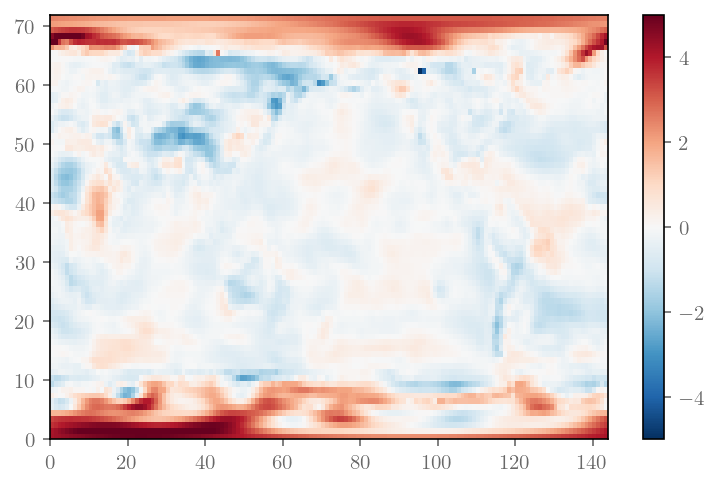

In [13]:
da_diff = da_obs_ncep - da_obs_best
da_diff_plot = np.mean(da_diff[-1:],axis=0)

fig = plt.figure(figsize=(6.,3.75))
plt.pcolor(da_diff_plot,cmap="RdBu_r")
plt.clim(-5,5)
plt.colorbar()

In [14]:
print('PLOT_SEED = ' + str(PLOT_SEED))

PLOT_SEED = 2247
